In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

In [2]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####


class data(Dataset):
    def __init__(self, path):
        self.len = 500
        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)
        src = cv2.imread('testingML.png', cv2.IMREAD_GRAYSCALE)
        self.Items = []

        for k in range(0,self.len):
            translationX = random.uniform(50, 80) * random.choice([1, -1])
            warped = cv2.warpAffine(src, np.array([[1., 0., translationX], [0., 1., 0.]]), (1440, 1440))

            margin = 80
            img = src[margin:-margin, margin:-margin]
            warped = warped[margin:-margin, margin:-margin]

            img = cv2.resize(img, (128, 128))
            warped = cv2.resize(warped, (128, 128))

            stacked = torch.stack((convert_tensor(img), convert_tensor(warped)))

            self.Items.append((stacked, torch.FloatTensor([1., 0., translationX, 0., 1., 0.])))

    # the function returns length of data
    def __len__(self):
        return self.len

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [3]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(32768, 1024)

        self.fc10 = nn.Linear(1024, 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = self.conv1(x)
        x = self.conv2(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv3(x)
        x = self.conv4(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv5(x)
        x = self.conv6(x)

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = self.conv7(x)
        x = self.conv8(x)
            
        return x

    def forward(self, x):

        self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = self.fc9(x)
        x = self.fc10(x)
        
        return x


In [4]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).mean()

#### Create data ####

Dataset = data('testingML.png')
train_set, val_set = torch.utils.data.random_split(Dataset, [400,100])
train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net()

loss_function = weighted_mse_loss

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

Epochs = 13
# Learning
for epoch in range(Epochs):
    for dataBatch in train_dataloader:
        Images, groundTruths = dataBatch

        optimizer.zero_grad()

        outputs = net(Images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,6), torch.FloatTensor([0, 0, 1, 0, 0, 0]))
        loss.backward() 
        optimizer.step() 
    # Training
    print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 466.45587158203125
Epoch: 1. Loss: 449.3677062988281
Epoch: 2. Loss: 282.9911193847656
Epoch: 3. Loss: 263.14697265625
Epoch: 4. Loss: 186.79518127441406
Epoch: 5. Loss: 84.57855224609375
Epoch: 6. Loss: 21.85657501220703
Epoch: 7. Loss: 7.94687032699585
Epoch: 8. Loss: 6.475992679595947
Epoch: 9. Loss: 5.264805316925049
Epoch: 10. Loss: 3.5915937423706055
Epoch: 11. Loss: 3.3015568256378174
Epoch: 12. Loss: 3.6908435821533203


In [8]:
bestLoss = 99999
bestOutput = 0
bestBatch = 0

with torch.no_grad():
        for dataBatch in val_dataloader:
                Images, groundTruths = dataBatch
                outputs = net(Images.view(-1, 2, 128, 128)) 

                loss = loss_function(outputs, groundTruths.view(-1,6), torch.FloatTensor([1, 1, 0.001, 1, 1, 0.001]))
                if(loss < bestLoss):
                        bestLoss = loss
                        bestOutput = outputs
                        bestBatch = dataBatch

im, gt = bestBatch

np.set_printoptions(precision=3, suppress=True)

print(f"Ground Truth :\n {np.array(gt[0].view(2,3))}")
print(f"Transofrm    :\n {np.array(bestOutput[0].view(2,3))}")
print(f"loss: {bestLoss}")
            

Ground Truth :
 [[ 1.     0.    67.961]
 [ 0.     1.     0.   ]]
Transofrm    :
 [[ 0.013 -0.009 67.303]
 [-0.002  0.002 -0.01 ]]
loss: 0.3285076916217804


In [ ]:
random.sample( val_dataloader, 20 )

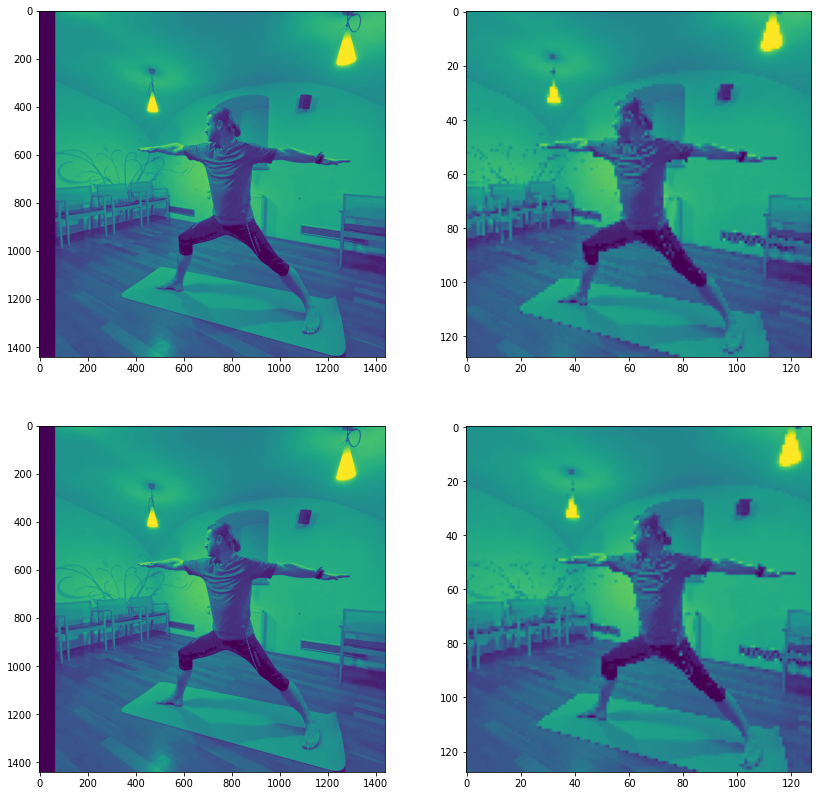

In [11]:
src = cv2.imread('testingML.png', cv2.IMREAD_GRAYSCALE)

transform = np.array(gt[0].view(2,3))
warped = cv2.warpAffine(src, transform, (1440, 1440))

fig, axes = plt.subplots(2, 2, figsize=(14, 14))


axes[0][0].imshow(warped)

transform = np.array([[1,0,bestOutput[0][2]], [0,1,0]])
warped = cv2.warpAffine(src, transform, (1440, 1440))

axes[1][0].imshow(warped)

axes[0][1].imshow(im[0][0].view(128,128))

axes[1][1].imshow(im[0][1].view(128,128))


In [7]:
loss = loss_function(torch.FloatTensor([[1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0]]),
                     torch.FloatTensor([[1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0]]),
                     torch.FloatTensor([1, 1, 0.001, 1, 1, 0.001]))
loss

tensor(0.)